# 1-2 DDPM算法
(目录)

## 0 章节目标
- 理解DDPM算法的扩散和恢复过程
- 了解可控生成过程

*代码以及相关理论重要参考*：
> [Probabilistic Diffusion Model概率扩散模型理论与完整PyTorch代码详细解读](https://www.bilibili.com/video/BV1b541197HX/?spm_id_from=333.999.0.0&vd_source=f1a43cfabe61c271b4df05136a41d18c)
> [Generative Modeling by Estimating Gradients of the Data Distribution](https://yang-song.net/blog/2021/score/)

## 1 数学基础

### 1.1 条件概率的一般形式
乘法公式 $P(A)>0, P(AB)=P(A)P(B|A)$

-> 推广 $P(A,B,C) = P(C|B,A)P(B,A) = P(C|B,A)P(B|A)P(A)$

-> $P(B,C|A) = P(B|A)P(C|A,B)$

### 1.2 基于马尔科夫假设的条件概率
马尔可夫性：给定过去的状态$A=\left \{ X_{0},X_{1},...,X_{n-1}  \right \}$和现在的状态$B=X_{n}$，将来的状态$C=X_{n+1}$的条件分布与过去的状态独立，只依赖于现在的状态，这样的性质称为马尔可夫性。

则有:
$$P(A,B,C) = P(C|B)P(B|A)P(A)$$
$$P(B,C|A) = P(B|A)P(C|B)$$

### 1.3 高斯分布的KL散度公式
在统计学意义上来说，KL散度可以用来衡量两个分布之间的差异程度。若两者差异越小，KL散度越小，反之亦反。当两分布一致时，其KL散度为0。正是因为其可以衡量两个分布之间的差异，所以在VAE、EM、GAN中均有使用到KL散度。

假设 p 和 q 均是服从正态分布$N(\mu 1,\rho 1)$
和$N(\mu 2,\rho 2)$的随机变量的概率密度函数，则从 q 到 p 的KL散度定义为：

$$KL(p\left |  \right |q)=\int [log(p(x))-log(q(x))]p(x)dx=\int [ p(x)log(p(x))-p(x)log(q(x))]dx$$

继续推导为：
$$KL(p,q)=log\frac{\rho 2}{\rho 1}+\frac{\rho 1^{2}+(\mu1-\mu 2)^2 }{2\rho 2^{2}} -\frac{1}{2}$$

详细推导参考：[KL-DivergenceIntroduction](https://hsinjhao.github.io/2019/05/22/KL-DivergenceIntroduction/)

### 1.4 重参数化技巧
假设要从标准正态分布$N(0,1)$中采样，在该分布中采样数据$\epsilon$，经过变换后得到$Z=\mu+\rho \epsilon$ ,其中$\mu$为均值，$\rho $为方差，从而将随机性转移至$Z$。

## 2 数学推导

### 2.1 正向加噪过程
定义一个真实数据分布中采样的点$\mathbf{x}_0 \sim q(\mathbf{x})$，前向过程则是逐渐在这个采样中加入$T$次高斯噪声，这形成一系列高斯噪声采样$\mathbf{x}_1, \dots, \mathbf{x}_T$，其中步长由变量$\{\beta_t \in (0, 1)\}_{t=1}^T$控制。
这一过程数学描述为：
$$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$$

采样数据$\mathbf{x}_0$在$t$逐渐变大的过程中逐渐失去它原有的分布，当$T \to \infty$时，$\mathbf{x}_T$就等价于一个各向异性高斯分布。

<div style="text-align: center;">
<img alt="The Markov chain of forward (reverse) diffusion process of generating a sample by slowly adding (removing) noise." height="400" align="center" src="./images/1-2_1-ddpm.png" width="1000"/>
</div>


上述过程中一个很好的特性就是我们可以用崇拜采样的技巧实现采样任意步t的$\mathbf{x}_t$，定义$\alpha_t = 1 - \beta_t$和$\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$。

$
\begin{aligned}
\mathbf{x}_t
&= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1} & \text{ ;where } \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
&= \sqrt{\alpha_t \alpha_{t-1}} \mathbf{x}_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \bar{\boldsymbol{\epsilon}}_{t-2} & \text{ ;where } \bar{\boldsymbol{\epsilon}}_{t-2} \text{ merges two Gaussians (*).} \\
&= \dots \\
&= \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} \\
q(\mathbf{x}_t \vert \mathbf{x}_0)&= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}
$

### 2.2 反向去噪过程
我们将上述过程反过来采样$q(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$，我们将逐渐地从高斯噪声分布$\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$中逐恢复出真实的采样。但是有两点需要注意，首先是如果步长$\beta_t$太小则$q(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$也还是一个高斯噪声分布，然后是由于我们并不知道整体数据的真实分布所以我们并不能很简单的估计$q(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$。因此我们去用模型学习一个参数$p_\theta$来估计这个条件概率分布从而来实现这个反向过程。

$$p_\theta(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod^T_{t=1} p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) \quad
p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))$$

<div style="text-align: center;">
    <img alt="An example of training a diffusion model for modeling a 2D swiss roll data." height="800"  src="./images/1-2_2-diffusion-example.png" width="1000"/>
</div>

值得注意的是可以从$\mathbf{x}_0$很容易地控制这个反向的条件概率过程：
$$q(\mathbf{x}_{t-1} \vert \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; {\tilde{\boldsymbol{\mu}}}(\mathbf{x}_t, \mathbf{x}_0), {\tilde{\beta}_t} \mathbf{I})$$


更多数学推导详见：[What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#:~:text=Diffusion%20models%20are%20inspired%20by%20non-equilibrium%20thermodynamics.%20They,to%20construct%20desired%20data%20samples%20from%20the%20noise)

## 3 代码演示

### 3.1 依赖的第三方库安装

In [2]:
!pip install matplotlib numpy scikit-learn torch

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


### 3.2 构建目标数据集S

shape of s: (10000, 2)


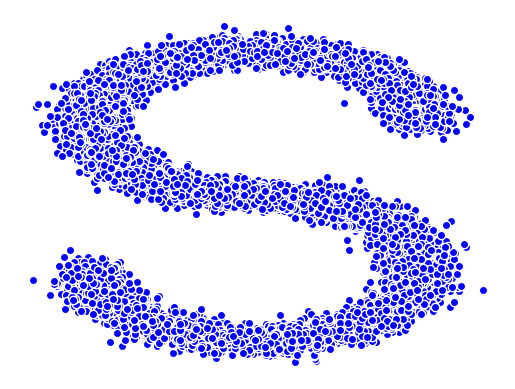

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

s_curve,_ = make_s_curve(10**4,noise=0.1)
s_curve = s_curve[:,[0,2]]/10.0

print("shape of s:",np.shape(s_curve))

data = s_curve.T

fig,ax = plt.subplots()
ax.scatter(*data,color='red',edgecolor='white');  # 规定生成点的样式

ax.axis('off')

dataset = torch.Tensor(s_curve).float()

### 3.3 确定超参数的值

In [9]:
num_steps = 100

# 制定每一步的beta
betas = torch.linspace(-6,6,num_steps)
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5

# 计算alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt等变量的值
alphas = 1-betas
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


### 3.4 确定扩散过程任意时刻的采样值

In [11]:
def q_x(x_0,t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    noise = torch.randn_like(x_0)  # 随机生成正态分布的噪声
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)  # 在x[0]的基础上添加噪声
    

### 3.5 演示原始数据分布加噪100步后的结果

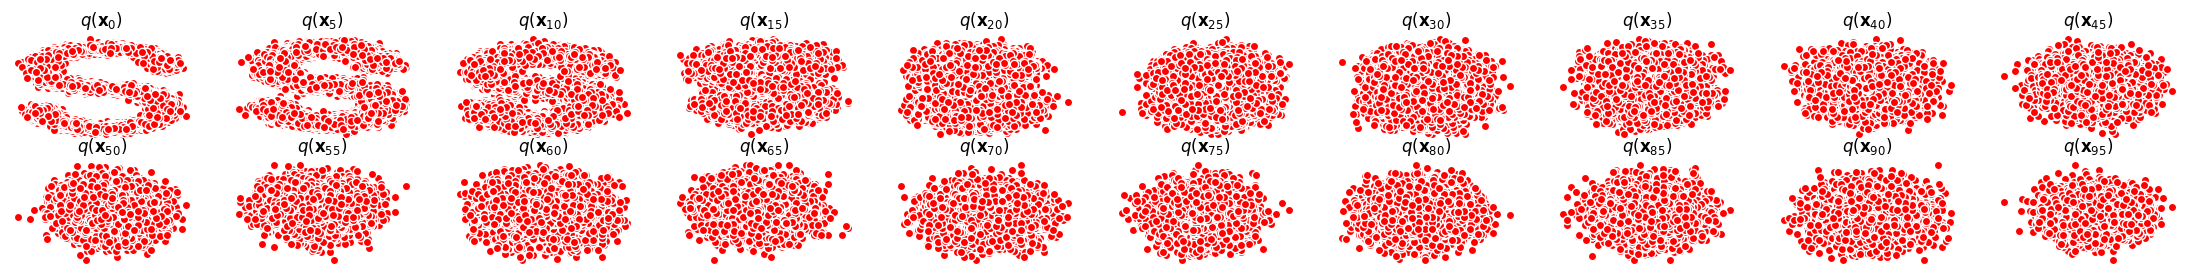

In [12]:
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

# 共有10000个点，每个点包含两个坐标
# 生成100步，每隔5步加噪声后的图像
for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows]))  # 生成t时刻的采样数据
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

### 3.6 编写拟合逆扩散过程高斯分布的模型
该模型主要是为了拟合${\epsilon}_\theta$，而它又跟$x$,$t$密切相关，因此知道输入输出，这里将复杂模型简化为几个感知层，构建如下。

In [13]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,num_units=128):
        super(MLPDiffusion,self).__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
            ]
        )
    def forward(self,x,t):
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
            
        x = self.linears[-1](x)
        
        return x

### 3.7 编写训练的loss函数

\begin{aligned}
L_t
&= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \Big[\frac{1}{2 \| \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t) \|^2_2} \| {\tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t, \mathbf{x}_0)} - {\boldsymbol{\mu}_\theta(\mathbf{x}_t, t)} \|^2 \Big] \\
&= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \Big[\frac{1}{2  \|\boldsymbol{\Sigma}_\theta \|^2_2} \| {\frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big)} - {\frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\boldsymbol{\epsilon}}_\theta(\mathbf{x}_t, t) \Big)} \|^2 \Big] \\
&= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \Big[\frac{ (1 - \alpha_t)^2 }{2 \alpha_t (1 - \bar{\alpha}_t) \| \boldsymbol{\Sigma}_\theta \|^2_2} \|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)\|^2 \Big] \\
&= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \Big[\frac{ (1 - \alpha_t)^2 }{2 \alpha_t (1 - \bar{\alpha}_t) \| \boldsymbol{\Sigma}_\theta \|^2_2} \|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t, t)\|^2 \Big]
\end{aligned}


In [ ]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]
    
    #对一个batchsize样本生成随机的时刻t
    t = torch.randint(0,n_steps,size=(batch_size//2,))
    t = torch.cat([t,n_steps-1-t],dim=0)
    t = t.unsqueeze(-1)
    
    #x0的系数
    a = alphas_bar_sqrt[t]
    
    #eps的系数
    aml = one_minus_alphas_bar_sqrt[t]
    
    #生成随机噪音eps
    e = torch.randn_like(x_0)
    
    #构造模型的输入
    x = x_0*a+e*aml
    
    #送入模型，得到t时刻的随机噪声预测值
    output = model(x,t.squeeze(-1))
    
    #与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

### 3.8 编写逆扩散采样函数（inference）

In [ ]:
def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t])
    
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x,t)
    
    mean = (1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta))
    
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z
    
    return (sample)

### 3.9 开始训练模型，打印loss及中间重构效果

In [ ]:
seed = 1234

print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
num_epoch = 4000
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps)#输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
        
    if(t%100==0):
        print(loss)
        x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
        
        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white');
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

### 3.10 动画演示扩散过程和逆扩散过程

In [ ]:
import io
from PIL import Image

imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset,torch.tensor([i]))
    plt.scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off');
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    imgs.append(img)

In [ ]:
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    reverse.append(img)

In [ ]:
imgs = imgs +reverse

In [ ]:
imgs[0].save("diffusion.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)